In [343]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import itertools
import matplotlib.patches as patches
import scipy.linalg as scp #to use make block diagonal matrix
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix, lil_matrix
import math

import time

Notation using Song, Z. et al. All ‘Magic Angles’ Are ‘Stable’ Topological. Phys. Rev. Lett. 123, 036401 (2019).


$$H_{Q Q'} (\textbf{k}) =v_f 2 K_D \sin(\theta/2) \left(\delta_{Q,Q'} (\textbf{k}-Q)\cdot \sigma + \frac{w}{v_f 2 K_D \sin(\theta/2)} \sum_{j=1}^{3} (\delta_{Q' - Q,q_j}+\delta_{Q - Q',q_j})T^j \right)$$
$$
q_1= R_{\theta/2}\textbf{K} - R_{-\theta/2} K = 2 K_D \sin(\theta/2)
\begin{pmatrix}
{0, \\ 1 } 
\end{pmatrix}, \; \;K_D = 4\pi/3\sqrt{3}a_G ,\\
q_2 = R_{2\pi/3} q_1 ,\\ 
q_3 = R_{2\pi/3} q_2 \\
T_j =\kappa \sigma_0 + \sigma _x \cos(2j\pi/3 ) + \sigma_ y \sin(2j\pi/3 ) 
$$


In [344]:
def RotMat(phi):
    return np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])

In [406]:
aG = 1 #Graphene lattice constant set to 1
theta =  (np.pi/180) *1.0595 #twist angle
Kd = 1 #4*np.pi/(3* np.sqrt(3)*aG ) #set to 1
q1 =np.array([0, 1]) #* 2*(Kd)*np.sin(theta/2)
q2 = RotMat(2*np.pi/3) @ q1
q3 = RotMat(2*np.pi/3) @ q2
b1 = q1 - q3 #reciprocal lattice vectors
b2 = q1 - q2
N1 = 20 
Gcut = 7  #cutoff for momentum space 
G = np.array([n*b1 + m*b2 for n, m in itertools.product(range(-N1, N1+1), repeat=2)]) 
G = np.array(sorted(G, key=lambda v: np.linalg.norm(v)))
LatA = np.array([ g  + q1 for g in G]) #top layer K points 
LatA = [v for v in LatA if np.linalg.norm(v) < Gcut]
LatB = np.array([ g  +2*q1 for g in G]) #bottom layer K points
LatB = [v for v in LatB if np.linalg.norm(v) < Gcut]
Q = np.concatenate((LatA, LatB)) #all K points
t = 2.8 #hopping parameter in eV
Escale = 4*t*np.sin(theta/2)*1000*np.pi/np.sqrt(3)#Escale in meV
Ndisc = 40 #number of discretization points for the BZ
BZ = [ m* b1/(2*Ndisc) + n*b2/(2*Ndisc) for m, n in itertools.product(range(-Ndisc, Ndisc), repeat=2)]



In [332]:
2*Kd*np.sin(theta/2) * Gcut/Kd  # maximum momentum in the moire Brillouin zone much smaller than dirac momentum 

0.1294404997235829

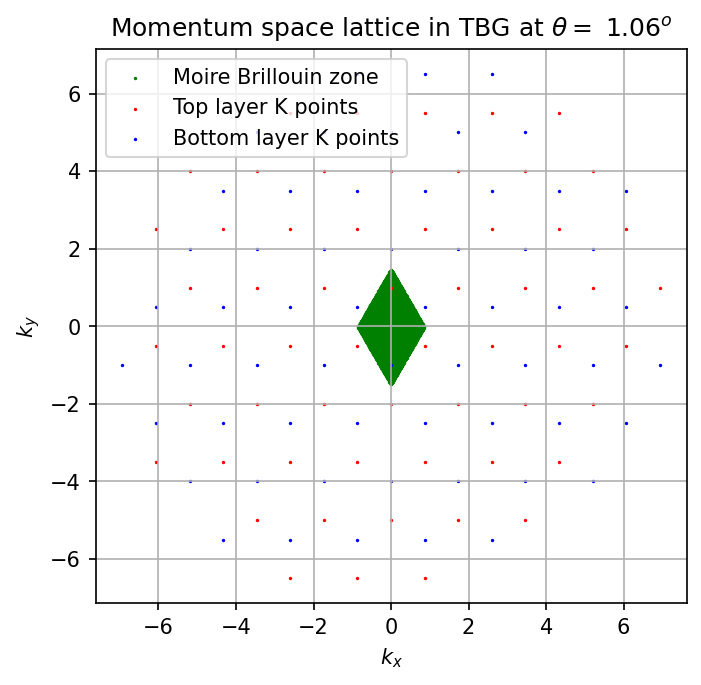

In [407]:
fig, ax = plt.subplots(dpi = 150)
x, y = zip(*LatA)
x1, y1 = zip(*LatB)
xp, yp = zip(*BZ)
ax.scatter(xp, yp, color='g', s=0.4,label='Moire Brillouin zone')
ax.scatter(x, y, color='r', s=0.4,label='Top layer K points')
ax.scatter(x1, y1, color='b', s=0.4,label='Bottom layer K points')

# Set the aspect ratio
ax.set_aspect('equal', 'box')
plt.title(f'Momentum space lattice in TBG at $ \\theta =$ {np.round(theta*180/np.pi,3)}$^o$')
plt.xlabel(f"$k_x$")
plt.ylabel(f"$k_y$")
plt.grid()
# Add a legend
ax.legend()

plt.show()


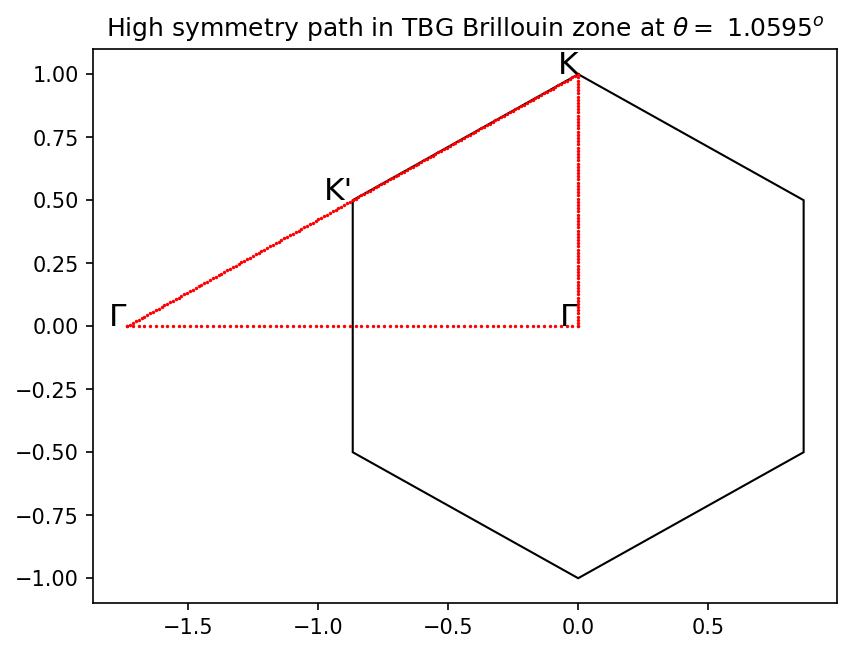

In [347]:
fig, ax = plt.subplots(dpi = 150)
gamma = np.array([0,0])
K = (b1 + b2)/3
Kp = RotMat(np.pi/3) @ K
gammap = b1 - b2
Npoints = 80
#Numppoints_unitlegth = 60

#kpath = np.concatenate((np.linspace(gamma, K, int(la.norm(gamma-K)*Numppoints_unitlegth)), np.linspace(K, Kp,  int(la.norm(K-Kp)*Numppoints_unitlegth)) , np.linspace(Kp, gammap,  int(la.norm(gamma-Kp)*Numppoints_unitlegth)) ,np.linspace(gammap, gamma, int(la.norm(gamma-gammap)*Numppoints_unitlegth)))) #k-path in momentum space
kpath = np.concatenate((np.linspace(gamma, K, Npoints), np.linspace(K, Kp, Npoints ) , np.linspace(Kp, gammap,  Npoints) ,np.linspace(gammap, gamma,  Npoints))) #k-path in momentum space
x, y = zip(*kpath)
hexagon = patches.Polygon([RotMat(l*np.pi/3) @ K for l in range(1,7)], closed=True, fill=False, edgecolor='black') #Brillouin zone hexagon
ax.add_patch(hexagon)
ax.scatter(x,y, color='r', s=0.4)
plt.title(f'High symmetry path in TBG Brillouin zone at $ \\theta =$ {np.round(theta*180/np.pi,4)}$^o$')

#labelling high symmetry points
txt = ['$\Gamma$', 'K', "K'", '$\Gamma$']
ax.text(gamma[0], gamma[1], txt[0], fontsize=15, ha='right')
ax.text(K[0], K[1], txt[1], fontsize=15, ha='right')
ax.text(Kp[0], Kp[1], txt[2], fontsize=15, ha='right')
ax.text(gammap[0], gammap[1], txt[3], fontsize=15, ha='right')

plt.show()

In [412]:
paulix = np.array([[0, 1], [1, 0]])
pauliy = np.array([[0, -1j], [1j, 0]])
pauliz = np.array([[1, 0], [0, -1]])
def dirac_ham(k):
    return paulix * k[0] + pauliy * k[1]
def ham(k,chiralratio,wAB):
    alpha = wAB/(3*t * 1000 *np.sin(theta/2)*4*np.pi/(3* np.sqrt(3) )  ) #dimensionless parameter
    tunnel_mat = lil_matrix((2*len(Q), 2*len(Q)),dtype=complex)
    T = [(chiralratio*np.identity(2) + np.cos(j*2*np.pi/3)*paulix  + np.sin(j*2*np.pi/3)*pauliy ) for j in range(3)]
    for i in range(len(Q)):
        for j in range(len(Q)):
            diff = Q[i] - Q[j]
            if math.isclose(la.norm(diff- q1),0, abs_tol=1e-7) :
                tunnel_mat[2*i:2*i+2,2*j:2*j+2] = T[0]
            elif math.isclose(la.norm(diff + q1),0, abs_tol=1e-7) :
                tunnel_mat[2*i:2*i+2,2*j:2*j+2] = T[0]
            elif math.isclose(la.norm(diff- q2),0, abs_tol=1e-7)  :
                tunnel_mat[2*i:2*i+2,2*j:2*j+2] = T[1]
            elif math.isclose(la.norm(diff+q2),0, abs_tol=1e-7)  :
                tunnel_mat[2*i:2*i+2,2*j:2*j+2] = T[1]
            elif math.isclose(la.norm(diff- q3),0, abs_tol=1e-7) :
                tunnel_mat[2*i:2*i+2,2*j:2*j+2] = T[2]
            elif math.isclose(la.norm(diff+ q3),0, abs_tol=1e-7) :
                tunnel_mat[2*i:2*i+2,2*j:2*j+2] = T[2]
    return scp.block_diag(*np.array([dirac_ham(k-Q[i]) for i in range(len(Q)) ])) +alpha*tunnel_mat

In [417]:
wABval = 110 #AB tunelling parameter meV
num_egn = 30 #number of eigenvalues to compute/k-point
band_struct = np.empty((num_egn, len(kpath))) # to store band structure
chiralrat = 0.7 #chiral ratio

def egnnonint(k,num_evals,chiralrat,wAB):
    st = time.time()
    ham_k = ham(k,chiralrat,wAB)#scp.block_diag(*np.array([dirac_ham(k-Q[i]) for i in range(len(Q)) ])) +alpha*tunnel_mat
    et = time.time()
    print(f'Time taken to create Hamiltonian matrix: {et-st} seconds')
    st = time.time()
    ev = eigsh(ham_k, k=num_evals, which='SM', return_eigenvectors=False)
    et = time.time()
    print(f'Time taken to diagonalize Hamiltonian matrix: {et-st} seconds')
    return ev

for i in range(len(kpath)) :
    evals = Escale*egnnonint(kpath[i],num_egn,chiralrat,wABval)
    band_struct[:,i] = np.sort(evals)


Time taken to create Hamiltonian matrix: 0.13595819473266602 seconds
Time taken to diagonalize Hamiltonian matrix: 0.03505587577819824 seconds
Time taken to create Hamiltonian matrix: 0.1574857234954834 seconds
Time taken to diagonalize Hamiltonian matrix: 0.0788118839263916 seconds
Time taken to create Hamiltonian matrix: 0.16874408721923828 seconds
Time taken to diagonalize Hamiltonian matrix: 0.05646991729736328 seconds
Time taken to create Hamiltonian matrix: 0.16423869132995605 seconds
Time taken to diagonalize Hamiltonian matrix: 0.056210994720458984 seconds
Time taken to create Hamiltonian matrix: 0.1506659984588623 seconds
Time taken to diagonalize Hamiltonian matrix: 0.10188007354736328 seconds
Time taken to create Hamiltonian matrix: 0.17899417877197266 seconds
Time taken to diagonalize Hamiltonian matrix: 0.0517580509185791 seconds
Time taken to create Hamiltonian matrix: 0.1520528793334961 seconds
Time taken to diagonalize Hamiltonian matrix: 0.06885409355163574 seconds
Tim

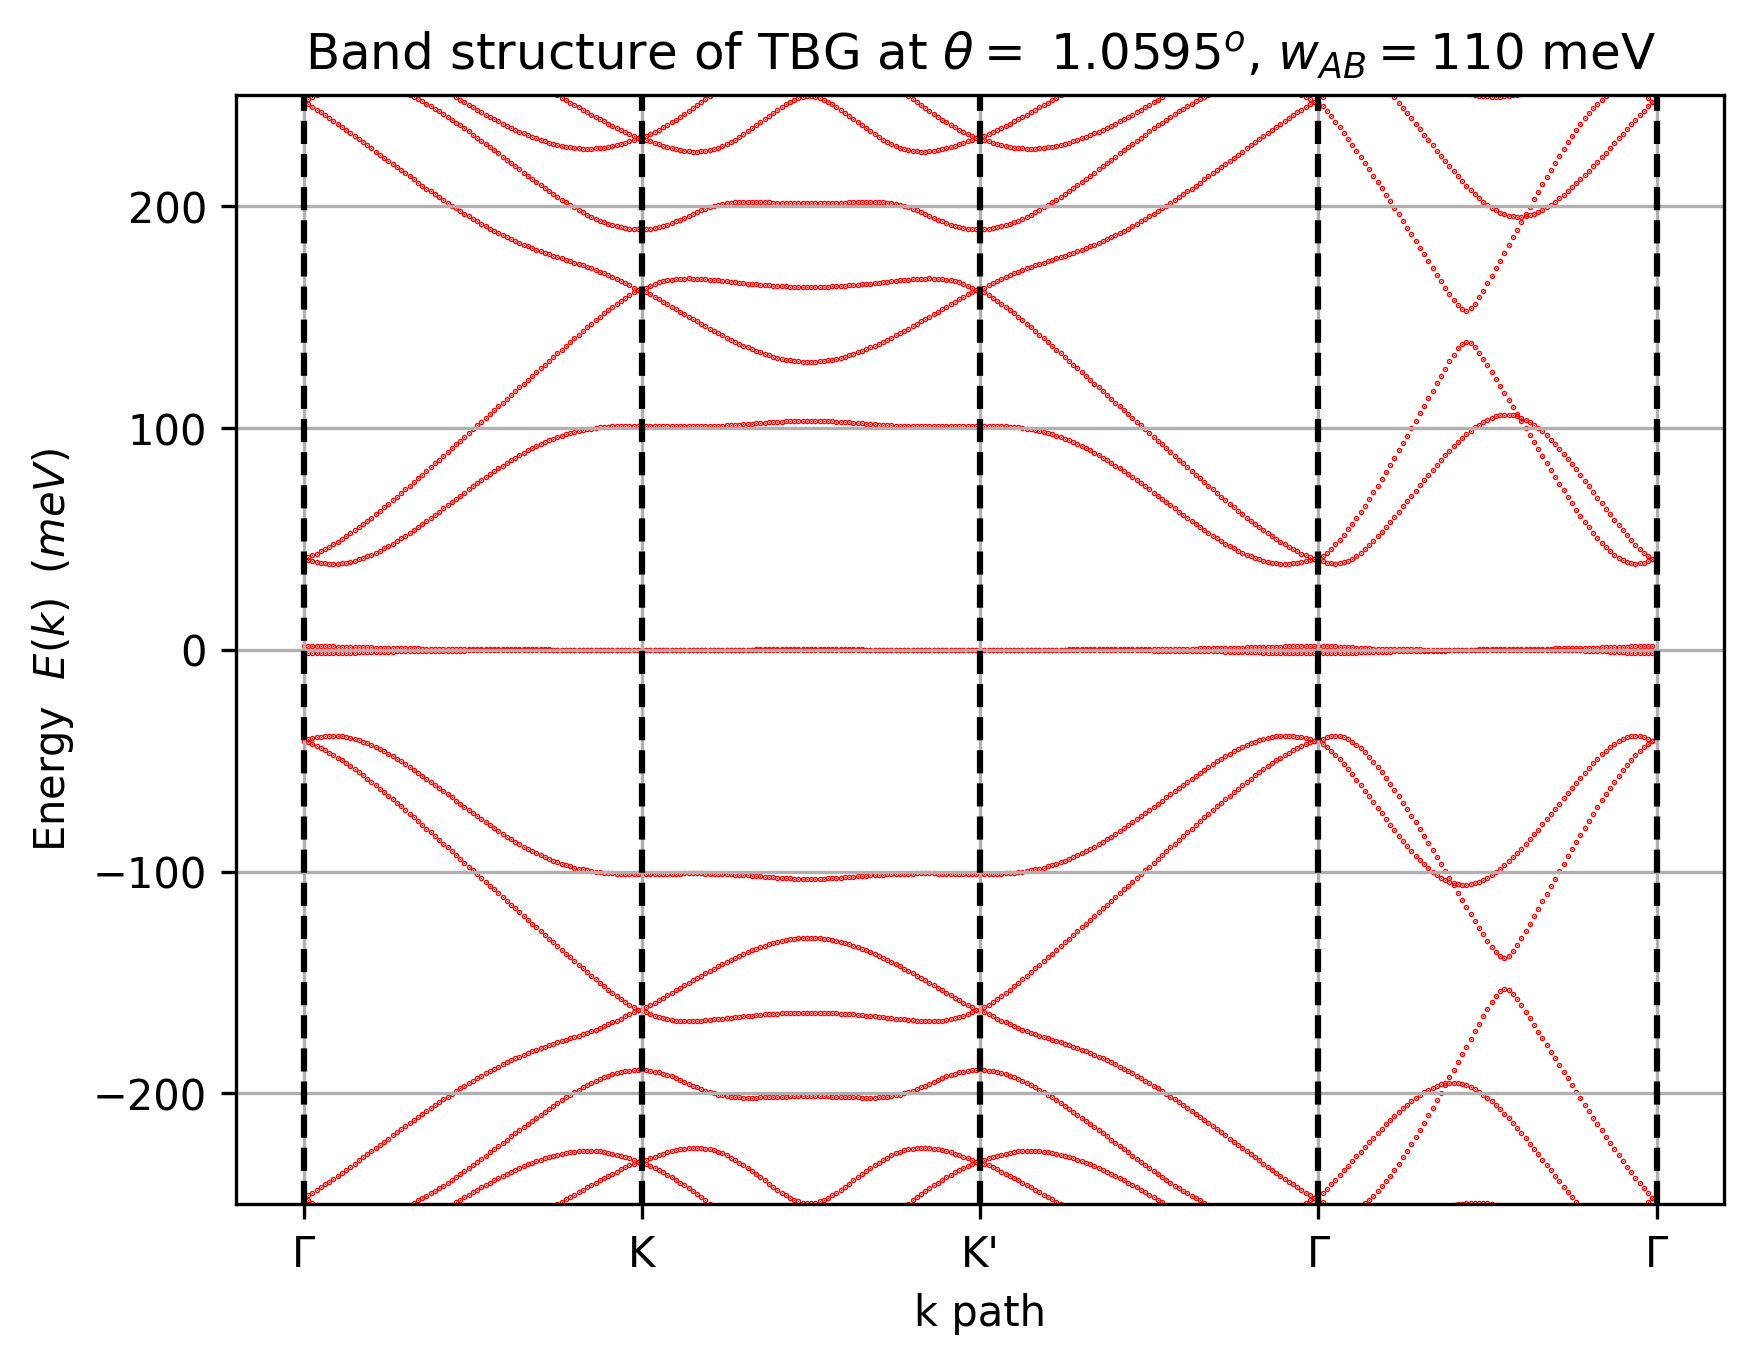

In [419]:
fig, ax = plt.subplots(dpi = 300)
plt.vlines([0,Npoints, 2*Npoints, 3*Npoints,4*Npoints], -250, 250, colors='k', linestyles='dashed')
for i in range(len(kpath)) :
    kp = np.array([i for j in range(num_egn)])
    plt.scatter(kp,band_struct[:,i], s=0.1, color='r')

plt.ylabel('Energy  $E(k)\;\; (meV)$')

plt.xlabel('k path')

plt.title(f'Band structure of TBG at $ \\theta =$ {np.round(theta*180/np.pi,5)}$^o$, $w_{{AB}} = {wAB}$ meV')

tick_positions = [0, Npoints, 2*Npoints, 3*Npoints,4*Npoints]
tick_labels = ['Γ', 'K', 'K\'', 'Γ', 'Γ']  # Example labels, replace with your actual labels
plt.xticks(tick_positions, tick_labels)
plt.grid()
plt.ylim(-250,250)
plt.show()

Density of states for band structure

In [408]:
band_struct_full = np.empty((num_egn, len(BZ))) # to store band structure

for i in range(len(BZ)) :
    evals = Escale * egnnonint(BZ[i])
    band_struct_full[:,i] = np.sort(evals)
    print(i)

Time taken to create Hamiltonian matrix: 0.003172159194946289 seconds
Time taken to diagonalize Hamiltonian matrix: 0.12785005569458008 seconds
0
Time taken to create Hamiltonian matrix: 0.0011701583862304688 seconds
Time taken to diagonalize Hamiltonian matrix: 0.1152796745300293 seconds
1
Time taken to create Hamiltonian matrix: 0.0031538009643554688 seconds
Time taken to diagonalize Hamiltonian matrix: 0.12955307960510254 seconds
2
Time taken to create Hamiltonian matrix: 0.0012569427490234375 seconds
Time taken to diagonalize Hamiltonian matrix: 0.11469101905822754 seconds
3
Time taken to create Hamiltonian matrix: 0.0018281936645507812 seconds
Time taken to diagonalize Hamiltonian matrix: 0.11849713325500488 seconds
4
Time taken to create Hamiltonian matrix: 0.0010991096496582031 seconds
Time taken to diagonalize Hamiltonian matrix: 0.11687827110290527 seconds
5
Time taken to create Hamiltonian matrix: 0.003572225570678711 seconds
Time taken to diagonalize Hamiltonian matrix: 0.11

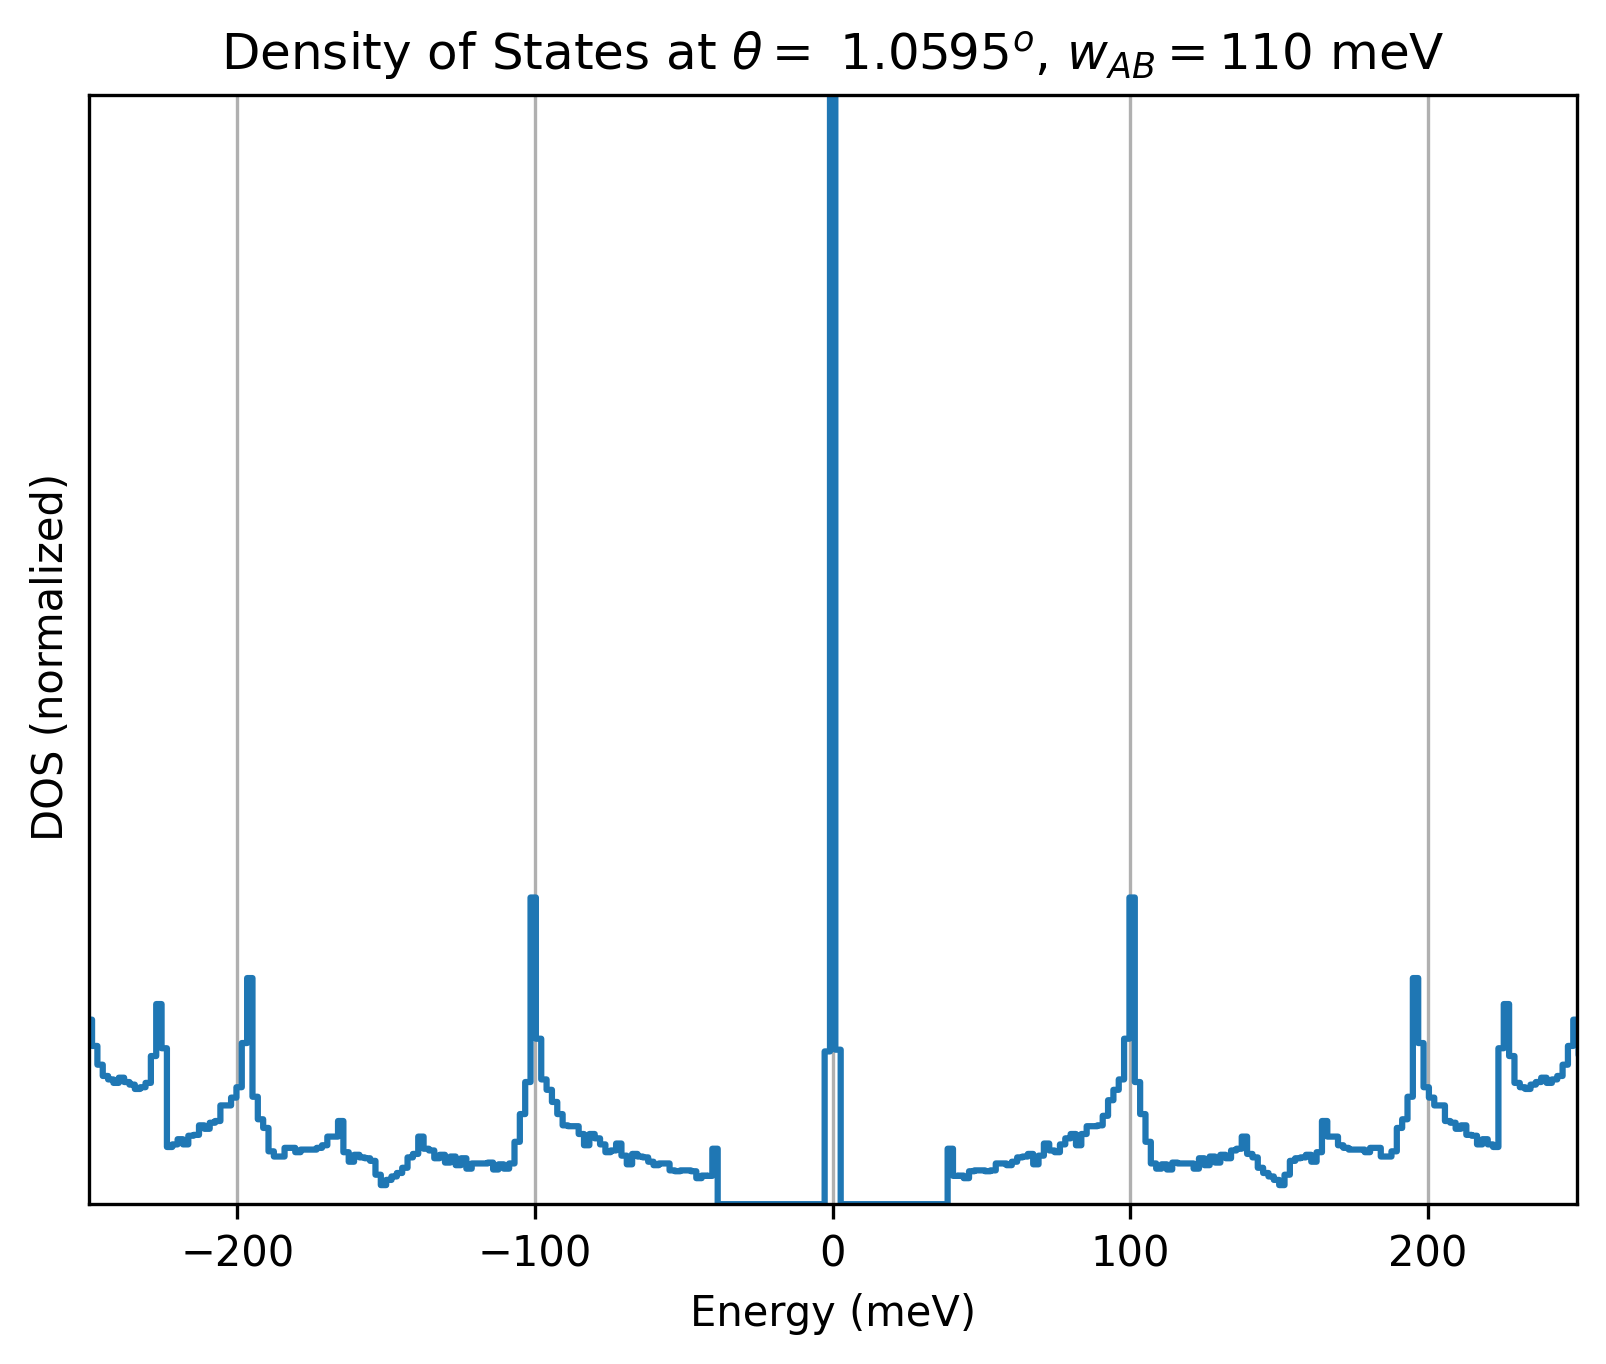

In [409]:
enval = np.sort(np.ravel(band_struct))
fig, ax = plt.subplots(dpi = 300)

# Compute the (DOS)
bin_edges = np.linspace(min(enval), max(enval),600)  
dos, edges = np.histogram(enval, bins=bin_edges)

# Normalized the DOS 
dos_normalized = dos / np.sum(dos)  # Example normalization

# Plotting the DOS
plt.plot(edges[:-1], dos_normalized, drawstyle='steps-post')
plt.xlabel('Energy (meV)')
plt.ylabel('DOS (normalized) ')
plt.yticks([])
plt.xlim(-250,250)
plt.ylim(0,0.015)
plt.title(f'Density of States at $ \\theta =$ {np.round(theta*180/np.pi,5)}$^o$, $w_{{AB}} = {wAB}$ meV')
plt.grid(True)
plt.show()
